In [ ]:
## original images are in shape(240,240,155) and are resized to >>> (128,128,155)
### mask file in folder 355 has weird name

In [ ]:
input_dir = './Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
# handle weird name
old=os.path.join(input_dir,'BraTS20_Training_355','W39_1998.09.19_Segm.nii')
new=os.path.join(input_dir,'BraTS20_Training_355','BraTS20_Training_355_seg.nii')
os.rename(old,new)

In [21]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class DataGenerator(Sequence):
    def __init__(self, list_IDs, input_dir, batch_size=2, dim=(128, 128), n_channels=4, n_classes=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.input_dir = input_dir
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        print(list_IDs_temp)
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_nifti_file(self, filepath):
        scan = nib.load(filepath)
        return scan.get_fdata()
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size * 155, *self.dim, self.n_channels))
        y = np.empty((self.batch_size * 155, *self.dim, self.n_classes), dtype=int)
        with tqdm(total=self.batch_size * 155, desc='Generating batch data', unit='slice') as pbar:
            for i, ID in enumerate(list_IDs_temp):
                # id_str = f"{int(ID):03d}"
                folder_name = os.path.join(self.input_dir, f'BraTS20_Training_{ID}')
                mask_name = f'BraTS20_Training_{ID}_seg'
                npy_mask = self.__load_nifti_file(os.path.join(folder_name, mask_name + '.nii'))
                for h in range(155):
                    mask = tf.one_hot(npy_mask[:, :, h], self.n_classes)
                    y[i * 155 + h] = tf.image.resize(mask, self.dim).numpy()
                    for k, modality in enumerate(['flair', 't1', 't1ce', 't2']):
                        channel_name = f'BraTS20_Training_{ID}_{modality}'
                        nmpy_channel = self.__load_nifti_file(os.path.join(folder_name, channel_name + '.nii'))
                        X[i * 155 + h, :, :, k] = cv2.resize(nmpy_channel[:, :, h], self.dim)
                    pbar.update(1)


        y[y == self.n_classes] = self.n_classes - 1
        return X, y
    
# Prepare IDs and data generators
input_dir = './Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
train_and_test_ids = [f.name.split('_')[-1] for f in os.scandir(input_dir) if f.is_dir()]
train_and_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_and_test_ids, test_size=0.15, random_state=42)

train_generator = DataGenerator(train_ids, input_dir)
val_generator = DataGenerator(val_ids, input_dir)
test_generator = DataGenerator(test_ids, input_dir)

['017', '191']


Generating batch data: 100%|██████████| 310/310 [00:12<00:00, 25.51slice/s]


Shape of X_batch: (310, 128, 128, 4)
Shape of y_batch: (310, 128, 128, 4)


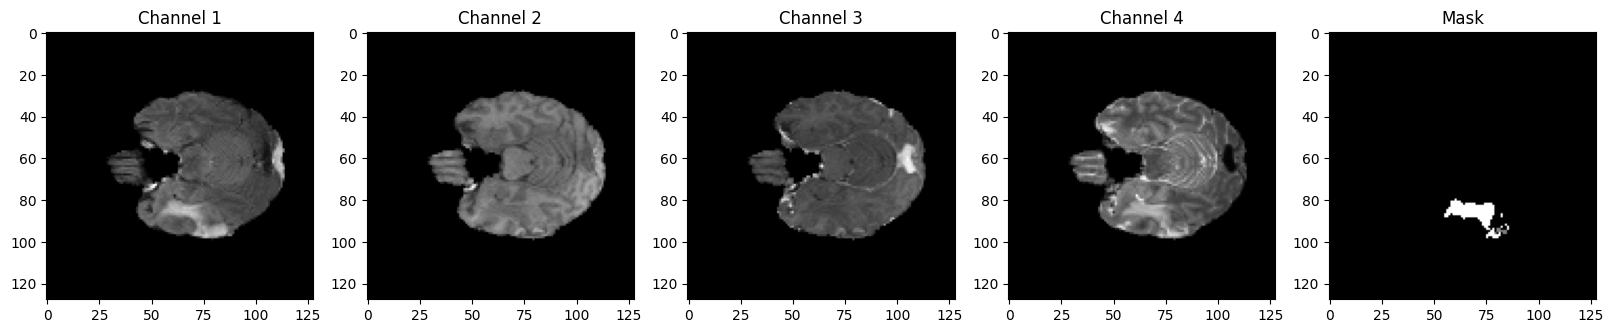

In [22]:
# Fetch one batch of data from the training generator
X_batch, y_batch = train_generator.__getitem__(0)

# Inspect the shape of the batch
print(f'Shape of X_batch: {X_batch.shape}')
print(f'Shape of y_batch: {y_batch.shape}')

# Visualize a slice from the batch
import matplotlib.pyplot as plt

# Choose an index from the batch
batch_index = 0  # first image in the batch
slice_index = 50  # choose a slice to visualize

# Plot the images for all channels and the corresponding mask
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

# Plot each channel
for i in range(4):
    axs[i].imshow(X_batch[batch_index * 155 + slice_index, :, :, i], cmap='gray')
    axs[i].set_title(f'Channel {i+1}')

# Plot the mask
axs[4].imshow(np.argmax(y_batch[batch_index * 155 + slice_index], axis=-1), cmap='gray')
axs[4].set_title('Mask')

plt.show()
